In [1]:
import VariationalBayes as vb
import autograd
from VariationalBayes import Modeling as modeling

import autograd.numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
def fun(z):
    return np.log1p(np.exp(z))

def fun_grad(z):
    return np.exp(z) / (1 + np.exp(z))

def fun_hess(z):
    p = np.exp(z) / (1 + np.exp(z))
    return p * (1 - p)

def log_fun(z):
    return np.log(fun(z))

def log_fun_grad(z):
    return 0. * fun(z)
    return fun_grad(z) / fun(z)

def log_fun_hess(z):
    f_z = fun(z)
    return 0. * f_z
    return fun_hess(z) / f_z - (fun_grad(z) / f_z) ** 2

std_draws = modeling.get_standard_draws(20)

z_mean = np.random.random((3, 5)) + 2.0
z_sd = np.exp(np.random.random((3, 5)) - 1.0)

z0 = z_mean
imp_means = modeling.importance_sampling_integrate_univariate_normal(
    z_mean, z_sd, z0, log_fun, log_fun_grad, log_fun_hess, std_draws, aggregate_all=False)

print(imp_means)

[[ 2.42794278  2.31542069  2.63453555  2.3813179   2.86021061]
 [ 2.94272615  2.80561421  2.43277259  3.05773451  2.76670037]
 [ 2.22354862  2.86485362  2.59778288  2.59070149  2.28417594]]


In [ ]:
draws_axis = z_sd.ndim
z_draws = \
    np.expand_dims(z_sd, axis=draws_axis) * std_draws + \
    np.expand_dims(z_mean, axis=draws_axis)

# By dividing by the number of standard draws after summing,
# we add the sample means for all the observations.
# Note that
# log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
logit_term = \
    np.sum(np.log1p(np.exp(z_draws))) / std_draws.size


In [13]:
std_draws_vec = [ 3, 5, 10, 30, 50, 100, 200, 500, 5000 ]

imp_means = \
    [ modeling.importance_sampling_integrate_univariate_normal(
      z_mean, z_sd, z0, log_fun, log_fun_grad, log_fun_hess,
      modeling.get_standard_draws(num_std_draws), aggregate_all=True) \
      for num_std_draws in std_draws_vec ]
    
direct_means = \
    [ modeling.get_e_logistic_term_only(z_mean, z_sd, modeling.get_standard_draws(num_std_draws)) \
      for num_std_draws in std_draws_vec ]

plt.plot(np.log10(std_draws_vec), direct_means, 'k.')
plt.plot(np.log10(std_draws_vec), imp_means, 'r.')

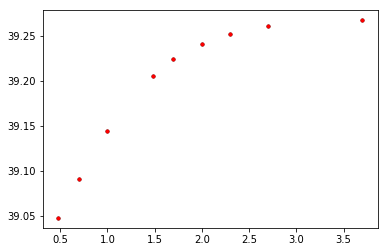

In [14]:

plt.plot(np.log10(std_draws_vec), direct_means, 'k.')
plt.plot(np.log10(std_draws_vec), imp_means, 'r.')

In [3]:
from VariationalBayes.Modeling import univariate_normal_log_prob

# q(u) will be a univariate normal importance sampling distribution.
# Its natural parameters are given by a Taylor expansion of log_fun.
z_info = 1 / z_sd ** 2

z_nat_param = z_info * z_mean
z2_nat_param = -0.5 * z_info

u_nat_param = z_nat_param + log_fun_grad(z0)
u2_nat_param = z2_nat_param + log_fun_hess(z0)

u_info = -2 * u2_nat_param
u_sd = 1. / np.sqrt(u_info)
u_mean = u_nat_param / u_info

# print('log fun --------')
# print(log_fun_grad(z0))
# print(log_fun_hess(z0))

# print('z nat params --------')
# print(z_nat_param)
# print(z2_nat_param)

# print('u nat parmas --------')
# print(u_nat_param)
# print(u2_nat_param)

# print('u sd and mean --------')
# print(u_sd)
# print(u_mean)

# print('z sd and mean --------')
# print(z_sd)
# print(z_mean)

draws_axis = u_sd.ndim
u_draws = \
    np.expand_dims(u_sd, axis=draws_axis) * std_draws + \
    np.expand_dims(u_mean, axis=draws_axis)

u_log_prob = univariate_normal_log_prob(
    u_draws,
    np.expand_dims(u_mean, axis=draws_axis),
    np.expand_dims(u_info, axis=draws_axis))
z_log_prob = univariate_normal_log_prob(
    u_draws,
    np.expand_dims(z_mean, axis=draws_axis),
    np.expand_dims(z_info, axis=draws_axis))
log_f_z = log_fun(u_draws)

# Importance sampling
log_imp_weights = np.exp(z_log_prob + log_f_z - u_log_prob)

result = np.sum(log_imp_weights, axis=draws_axis) / len(std_draws)

print(result)

[[ 0.93572958  0.7626296   1.15765484  1.04964799  0.84785575]
 [ 0.94445288  0.98396326  1.16130879  1.28169693  0.90664068]
 [ 0.92360028  1.30242094  1.31187953  0.87827439  1.27274373]]


In [32]:
import VariationalBayes as vb
import Models.LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from autograd import jacobian

import copy
from scipy import optimize

import os
import json

analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
vp_base = json_dat['vp_base']

print(stan_dat.keys())
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
#N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

mu_info_min = vp_base['mu_info_min'][0]
tau_alpha_min = vp_base['tau_alpha_min'][0]
tau_beta_min = vp_base['tau_beta_min'][0]
beta_diag_min = vp_base['beta_diag_min'][0]
u_info_min = vp_base['u_info_min'][0]

# Define a class to contain prior parameters.
prior_par = vb.ModelParamsDict('Prior Parameters')

prior_par.push_param(vb.VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
prior_par.push_param(vb.PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

prior_par.push_param(vb.ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
prior_par.push_param(vb.ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

prior_par.push_param(vb.ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
prior_par.push_param(vb.ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))

glmm_fit = json_dat['glmm_fit']
glmm_par['mu'].mean.set(glmm_fit['mu_mean'][0])
glmm_par['mu'].info.set(1.0)

tau_mean = 1.0 / glmm_fit['mu_sd'][0] ** 2
tau_var = 1.0
glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
glmm_par['tau'].rate.set(tau_var / tau_mean)

glmm_par['beta'].mean.set(np.array(glmm_fit['beta_mean']))
glmm_par['beta'].info.set(np.eye(K))

glmm_par['u'].mean.set(np.array(glmm_fit['u_map']))
glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


dict_keys(['mu_prior_mean_c', 'beta_prior_var', 'NG', 'mu_prior_var', 'N', 'y_group', 'mu_prior_epsilon', 'x', 'tau_prior_alpha', 'K', 'tau_prior_beta', 'beta_prior_mean', 'mu_prior_var_c', 'y', 'mu_prior_mean', 'mu_prior_t'])


In [33]:
glmm_par = vb.ModelParamsDict('GLMM Parameters')

# print(vp_base)

glmm_par.push_param(
    vb.UVNParam('mu', min_info=mu_info_min))
glmm_par.push_param(
    vb.GammaParam('tau', min_shape=tau_alpha_min, min_rate=tau_beta_min))
glmm_par.push_param(vb.MVNParam('beta', K, min_info=beta_diag_min))
glmm_par.push_param(vb.UVNParamVector('u', NG, min_info=u_info_min))

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_draws, maxiter=500):
    model.set_draws(num_draws)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': 1e-6 })
    return vb_opt.x


In [34]:
e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]
cov_beta = glmm_par['beta'].cov()
var_u = glmm_par['u'].var()


z_mean = e_u[y_g_vec] + np.matmul(x_mat, e_beta)
z_sd = np.sqrt(
    var_u[y_g_vec] + np.einsum('nk,kj,nj->n',
                      x_mat, cov_beta, x_mat))

std_draws_vec = [ 3, 5, 10, 30, 50, 100, 200, 500, 5000 ]

z0 = z_mean
print('Importance sampling')
imp_means = \
    [ modeling.importance_sampling_integrate_univariate_normal(
      z_mean, z_sd, z0, log_fun, log_fun_grad, log_fun_hess,
      modeling.get_standard_draws(num_std_draws), aggregate_all=True) \
      for num_std_draws in std_draws_vec ]
    
print('Direct sampling')
direct_means = \
    [ modeling.get_e_logistic_term_only(z_mean, z_sd, modeling.get_standard_draws(num_std_draws)) \
      for num_std_draws in std_draws_vec ]



(13014,)


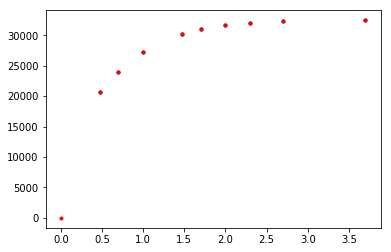

In [35]:
print(z_mean.shape)

plt.plot(np.log10(std_draws_vec), direct_means, 'k.')
plt.plot(np.log10(std_draws_vec), imp_means, 'r.')
plt.plot(0, 0, 'r.')
